<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !if [ -d deepul ]; then rm -Rf deepul; fi
    !git clone -b magda https://github.com/mgswiss15/deepul.git 
    !unzip -qq deepul/homeworks/hw2/data/hw1_data.zip -d deepul/homeworks/hw2/data/
    !pip install ./deepul
else:
    %load_ext autoreload
    %autoreload 2
    import sys
    import pathlib
    cwd = pathlib.Path().absolute()
    sys.path.append(str(cwd.parents[0]))
    sys.path.append(str(cwd.parents[1]))
    print(sys.path)

['/home/magda/Github/deepul/homeworks/hw2', '/home/magda/anaconda3/envs/pytorch/lib/python38.zip', '/home/magda/anaconda3/envs/pytorch/lib/python3.8', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/lib-dynload', '', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions', '/home/magda/.ipython', '/home/magda/Github/deepul/homeworks', '/home/magda/Github/deepul']


In [2]:
from deepul.hw2_helper import *

# Question 2: Autoregressive Flows for Images [20pt]
We can scale up the autoregressive flows from 1(a) to high-dimensional image data. In this question, we will focus on the black-and-white shapes dataset from Homework 1.

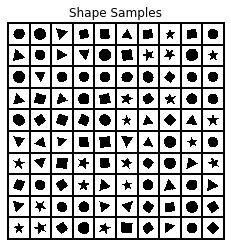

In [3]:
visualize_q2_data()

Adapt your PixelCNN implementation from Homework 1 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 1 3(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

#### How to use torch.gather
check here: https://medium.com/analytics-vidhya/understanding-indexing-with-pytorch-gather-33717a84ebc4

In [33]:
batch_size = 8
max_seq_len = 9
hidden_size = 6
x = torch.empty(batch_size, max_seq_len, hidden_size)
for i in range(batch_size):
  for j in range(max_seq_len):
    for k in range(hidden_size):
      x[i,j,k] = i + j*10 + k*100
    
print(x[:,4,:])
indices = torch.ones(8, 1, 6)
indices = indices.long()
print(indices.dtype)
results = torch.gather(x, 1, indices)
print(results)

tensor([[ 40., 140., 240., 340., 440., 540.],
        [ 41., 141., 241., 341., 441., 541.],
        [ 42., 142., 242., 342., 442., 542.],
        [ 43., 143., 243., 343., 443., 543.],
        [ 44., 144., 244., 344., 444., 544.],
        [ 45., 145., 245., 345., 445., 545.],
        [ 46., 146., 246., 346., 446., 546.],
        [ 47., 147., 247., 347., 447., 547.]])
torch.int64
tensor([[[ 10., 110., 210., 310., 410., 510.]],

        [[ 11., 111., 211., 311., 411., 511.]],

        [[ 12., 112., 212., 312., 412., 512.]],

        [[ 13., 113., 213., 313., 413., 513.]],

        [[ 14., 114., 214., 314., 414., 514.]],

        [[ 15., 115., 215., 315., 415., 515.]],

        [[ 16., 116., 216., 316., 416., 516.]],

        [[ 17., 117., 217., 317., 417., 517.]]])


In [41]:
from deepul.exp_utils2 import *
from torch.distributions import Normal

def dequantize(data):
    '''Uniform deuqantization'''
    if isinstance(data, np.ndarray):
        data = torch.as_tensor(data, dtype=torch.float)
    noise = torch.rand_like(data)
    data = data + noise
    data = data / 2.
    return data


class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.mask = nn.Parameter(torch.zeros(out_channels, in_channels, *self.kernel_size), requires_grad=False)
        k_size = self.kernel_size[0]
        kernel_mid = k_size // 2
        if kernel_mid==0:
            self.mask[:] = 1.
        else:
            for i in range(k_size):
                for j in range(k_size):
                    if i < kernel_mid:
                        self.mask[:, :, i, j] = 1.
                    elif (i == kernel_mid) & (j < kernel_mid):
                        self.mask[:, :, i, j] = 1.
        
    def forward(self, x):
        return self._conv_forward(x, self.weight * self.mask)   
    

class PixelCNN(nn.Module):
    def __init__(self, n_comp=5, filters=64):
        super(PixelCNN, self).__init__()
        self.n_comp = n_comp
        self.filters = filters
        layers = []
        layers.append(MaskedConv2d(1, self.filters, 7, stride=1, padding=3))
        for i in range(5):
            layers.append(nn.ReLU())
            layers.append(MaskedConv2d(self.filters, self.filters, 7, stride=1, padding=3))
        layers.append(nn.ReLU())
        layers.append(MaskedConv2d(self.filters, self.filters, 1, stride=1, padding=0))
        layers.append(nn.ReLU())
        self.sequential = nn.Sequential(*layers)
        self.l_mus = MaskedConv2d(self.filters, self.n_comp, 1, stride=1, padding=0)
        self.l_logsigmas = MaskedConv2d(self.filters, self.n_comp, 1, stride=1, padding=0)
        self.l_weight_logits = MaskedConv2d(self.filters, self.n_comp, 1, stride=1, padding=0)
       
    def forward(self, x):
        out = self.sequential(x)
        mus = self.l_mus(out)
        logsigmas = self.l_logsigmas(out)
        weight_logits = self.l_weight_logits(out)
        return mus, logsigmas, weight_logits   

    
class CdfFlow(nn.Module):
    def __init__(self):
        super(CdfFlow, self).__init__()
        
    def forward(self, x, mus, logsigmas, weight_logits):
        sigmas = logsigmas.exp()
        weights = F.softmax(weight_logits, dim=1) # careful about dim here (different from flow1)
        distrib = Normal(mus, sigmas)
        cdf = distrib.cdf(x)
        z = (weights * cdf).sum(1, keepdim=True)
        pdf = distrib.log_prob(x).exp()
        jacobian = (weights * pdf).sum(1, keepdim=True)
        return z, jacobian
    
    def inverse(self, z, mus, logsigmas, weight_logits):
        sigmas = logsigmas.exp()
        weights = F.softmax(weight_logits, dim=1) # careful about dim here (different from flow1)
        weights = weights.permute(0, 2, 3, 1)
        comps = torch.multinomial(weights.reshape([-1, weights.shape[3]]), 1)
        comps = comps.view(*weights.shape[:3], -1)
        comps = comps.permute(0, 3, 1, 2).long()
        mus = mus.gather(1, comps)
        sigmas = sigmas.gather(1, comps)
        distrib = Normal(mus, sigmas)
        x = distrib.icdf(z)
        return x
    
    
class AutoregressiveFlow(nn.Module):
    def __init__(self, height, width, n_comp=5, filters=64):
        super(AutoregressiveFlow, self).__init__()
        self.height = height
        self.width = width
        self.n_comp = n_comp
        self.filters = filters
        self.flow = CdfFlow()
        self.conditioner = PixelCNN(self.n_comp, self.filters)
        
    def forward(self, x):
        mus, logsigmas, weight_logits = self.conditioner(x)
        z, jacobian = self.flow(x, mus, logsigmas, weight_logits)
        return z, jacobian
    
    def inverse(self, x, z):
        mus, logsigmas, weight_logits = self.conditioner(x)
        return self.flow.inverse(z, mus, logsigmas, weight_logits)
    
    def log_prob_x_from_z(self, jacobians):
        # uniform.log_prob = 0 for U(0,1) so can be dropped from formula
        log_prob = jacobians.abs().log().sum(dim=[1, 2, 3])
        return log_prob
    
    def loss_function(self, z, jacobians):
        loss = -self.log_prob_x_from_z(jacobians).mean()
        return loss
    
    def eval_log_prob(self, x):
        self.eval()
        with torch.no_grad():
            zs, jacobians = self(x)
            log_prob = self.log_prob_x_from_z(jacobians)
        return log_prob
    
    def sampling(self, size):
        print(f'Begin sampling')
        self.eval()
        with torch.no_grad():
            sample = torch.rand((size, 1, self.height, self.width))
            if next(self.parameters()).is_cuda:
                sample = sample.cuda()
            z = torch.rand_like(sample)
            for i in range(self.height):
                for j in range(self.width):
                    sample[:, :, i, j] = self.inverse(sample, z)[:, :, i, j]
                print(f'Sampled row {i}')
            images = sample.permute(0, 2, 3, 1)
        return images

In [45]:
def q2(train_data, test_data):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    H = W = 20
    Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
    """

    """ YOUR CODE HERE """
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))
#     train_data = train_data[:10,:,:3, :3]
#     test_data = test_data[:10,:,:3, :3]
    train_data = dequantize(train_data)
    test_data = dequantize(test_data)
    height, width = train_data.shape[2:]

    DEVICE = torch.device('cuda')
    train_loader, test_loader = get_loaders(train_data, test_data, bs=128)

    model = AutoregressiveFlow(height, width, n_comp=5, filters=64).to(DEVICE)
    optim_algo = torch.optim.Adam
    nll_train, nll_test = training(
        train_loader, test_loader,
        model, optim_algo, learn_rate=1e-4, device=DEVICE, epochs=11)
    npixels = height*width
    nll_train = np.array(nll_train) / npixels
    nll_test = np.array(nll_test) / npixels
    return nll_train, nll_test, model.sampling(100).cpu().numpy()

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



Epoch 0 loss train: 115.59221649169922, test: 117.96218872070312
Epoch 10 loss train: -144.70675659179688, test: -144.88058471679688
Begin sampling
Sampled row 0
Sampled row 1
Sampled row 2
Sampled row 3
Sampled row 4
Sampled row 5
Sampled row 6
Sampled row 7
Sampled row 8
Sampled row 9
Sampled row 10
Sampled row 11
Sampled row 12
Sampled row 13
Sampled row 14
Sampled row 15
Sampled row 16
Sampled row 17
Sampled row 18
Sampled row 19
Final Test Loss: -0.3622


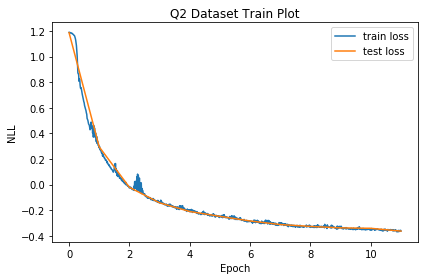

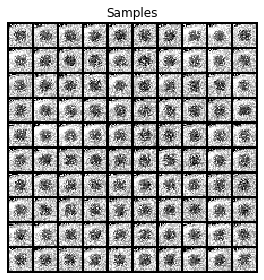

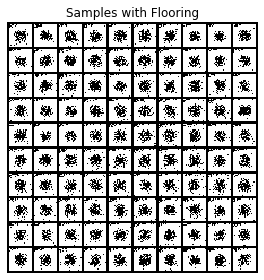

In [46]:
q2_save_results(q2)